In [91]:
import os
import numpy as np
from astropy.io import fits

# --- PARAMETRI ---

# Directory dei file FITS
reduced_dir = '/Users/claudiamurro/Desktop/laboratorio tecnologie astronomiche/cupani/reduced'

# Intervallo della sub-image da analizzare (zoom su zona target)
x_range = (550, 670)
y_range = (800, 920)

# Frame considerati outlier (puoi aggiungerli dopo l’analisi)
outlier_frames = []

# Lista per salvare le posizioni massime (centroidi approssimati)
max_positions = []

# --- LOOP SUI FRAME ---

for frame in range(1, 101):
    reduced_name = f'SZ_Lyn-{frame:04d}_reduced.fit'
    path = os.path.join(reduced_dir, reduced_name)

    try:
        with fits.open(path) as hdul:
            image = hdul[0].data.astype(np.float64)

        # Estrai la subimage per il target
        subimage = image[y_range[0]:y_range[1], x_range[0]:x_range[1]]

        # Trova la posizione del massimo nella regione (indice relativo)
        pos_max = np.unravel_index(np.nanargmax(subimage), subimage.shape)

        # Converte in coordinate assolute dell’immagine intera
        abs_x = x_range[0] + pos_max[1]
        abs_y = y_range[0] + pos_max[0]
        abs_pos = (abs_x, abs_y)

        max_positions.append(abs_pos)

        # Stampa
        if frame in outlier_frames:
            print(f"Frame {frame:04d} (OUTLIER): max pos (x, y) = {abs_pos}")
        else:
            print(f"Frame {frame:04d}: max pos (x, y) = {abs_pos}")

    except FileNotFoundError:
        print(f"File mancante: {reduced_name}")
        max_positions.append(None)

Frame 0001: max pos (x, y) = (614, 857)
Frame 0002: max pos (x, y) = (616, 857)
Frame 0003: max pos (x, y) = (615, 854)
Frame 0004: max pos (x, y) = (616, 857)
Frame 0005: max pos (x, y) = (617, 857)
Frame 0006: max pos (x, y) = (617, 858)
Frame 0007: max pos (x, y) = (618, 857)
Frame 0008: max pos (x, y) = (619, 858)
Frame 0009: max pos (x, y) = (616, 858)
Frame 0010: max pos (x, y) = (620, 858)
Frame 0011: max pos (x, y) = (620, 858)
Frame 0012: max pos (x, y) = (620, 854)
Frame 0013: max pos (x, y) = (620, 856)
Frame 0014: max pos (x, y) = (621, 856)
Frame 0015: max pos (x, y) = (619, 854)
Frame 0016: max pos (x, y) = (622, 857)
Frame 0017: max pos (x, y) = (622, 855)
Frame 0018: max pos (x, y) = (621, 856)
Frame 0019: max pos (x, y) = (623, 857)
Frame 0020: max pos (x, y) = (621, 855)
Frame 0021: max pos (x, y) = (621, 854)
Frame 0022: max pos (x, y) = (624, 856)
Frame 0023: max pos (x, y) = (626, 859)
Frame 0024: max pos (x, y) = (623, 854)
Frame 0025: max pos (x, y) = (625, 857)


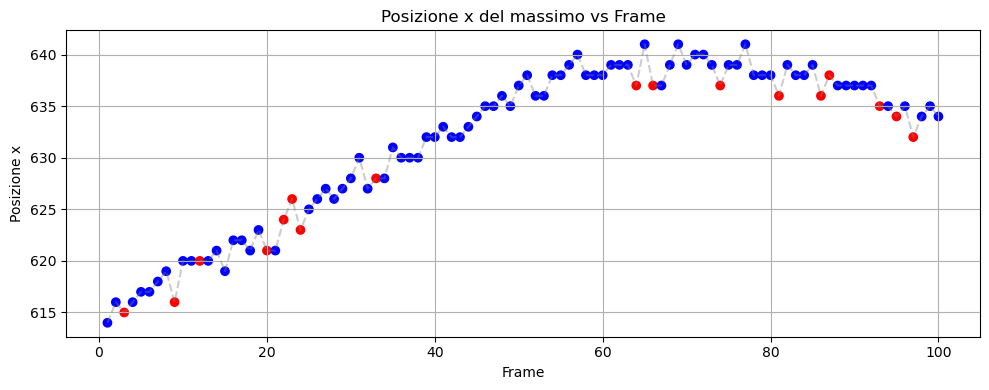

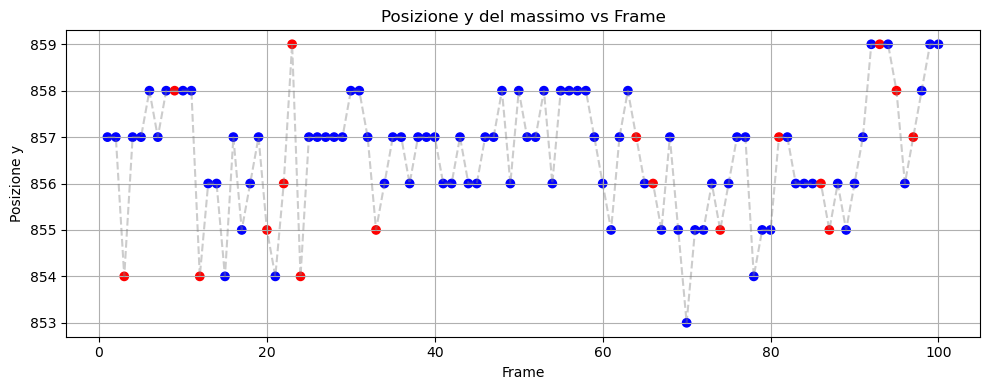

In [97]:
# Estrai le coordinate x e y dal risultato precedente
x_max = [pos[0] if pos is not None else np.nan for pos in max_positions]
y_max = [pos[1] if pos is not None else np.nan for pos in max_positions]
frames = np.arange(1, 101)

# Lista di frame outlier
outlier_frames = [3, 9, 12, 20, 22, 23, 24, 33, 64, 66, 74, 81, 86, 87, 93, 95, 97]

# Colori per evidenziare gli outlier
colors = ['red' if frame in outlier_frames else 'blue' for frame in frames]

# Grafico delle coordinate x del massimo
plt.figure(figsize=(10, 4))
plt.scatter(frames, x_max, c=colors)
plt.plot(frames, x_max, linestyle='--', color='gray', alpha=0.4)
plt.title('Posizione x del massimo vs Frame')
plt.xlabel('Frame')
plt.ylabel('Posizione x')
plt.grid(True)
plt.tight_layout()
plt.show()

# Grafico delle coordinate y del massimo
plt.figure(figsize=(10, 4))
plt.scatter(frames, y_max, c=colors)
plt.plot(frames, y_max, linestyle='--', color='gray', alpha=0.4)
plt.title('Posizione y del massimo vs Frame')
plt.xlabel('Frame')
plt.ylabel('Posizione y')
plt.grid(True)
plt.tight_layout()
plt.show()

Effettivamente si nota uno spostamento del massimo (specialmente per le x) della subimage

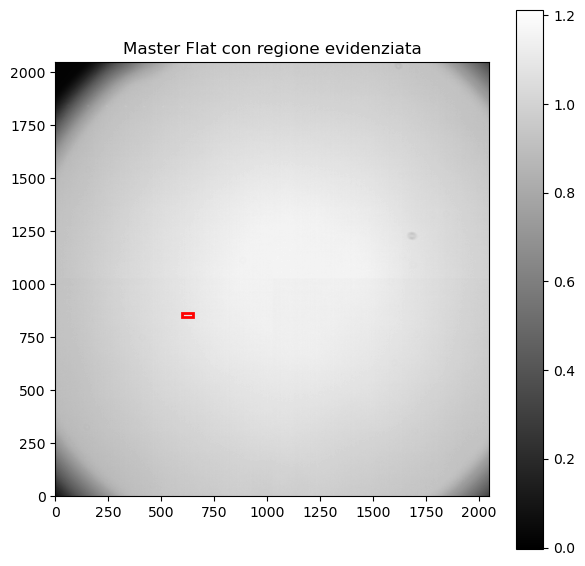

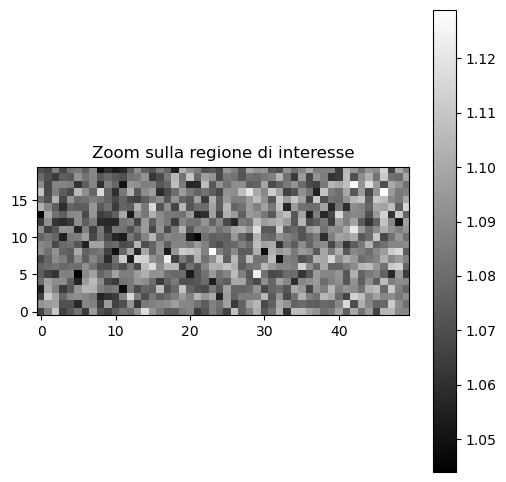

In [100]:
#vediamo cosa succede al master flat circa nella zona dei massimi 

# --- PARAMETRI DELLA REGIONE ---
#x_range = (550, 670)
#y_range = (800, 920)

x_range = (600, 650)
y_range = (845, 865)

# --- FUNZIONI ---

def load_fits_data(filepath):
    with fits.open(filepath) as hdul:
        return hdul[0].data.astype(np.float64)

def compute_master_frame(file_pattern, n_files, bias=None, dark=None):
    frames = [load_fits_data(file_pattern % i) for i in range(1, n_files + 1)]
    frames = np.array(frames)
    if bias is not None:
        frames -= bias
    if dark is not None:
        frames -= dark
    return np.median(frames, axis=0)

def normalize_flat(flat):
    return flat / np.mean(flat)

def show_flat_and_region(master_flat, x_range, y_range):
    # Flat completo con rettangolo
    plt.figure(figsize=(7, 7))
    plt.imshow(master_flat, origin='lower', cmap='gray')
    plt.colorbar()
    plt.title('Master Flat con regione evidenziata')
    rect = plt.Rectangle((x_range[0], y_range[0]), x_range[1] - x_range[0],
                         y_range[1] - y_range[0], linewidth=2,
                         edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)
    plt.show()

    # Zoom sulla regione
    zoom = master_flat[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    plt.figure(figsize=(6, 6))
    plt.imshow(zoom, origin='lower', cmap='gray')
    plt.colorbar()
    plt.title('Zoom sulla regione di interesse')
    plt.show()

# --- ESECUZIONE ---

# Percorso e parametri
calib_path = '/Users/claudiamurro/Desktop/laboratorio tecnologie astronomiche/cupani/calib'
bias_pattern = os.path.join(calib_path, 'bias-%04i.fit')
dark_pattern = os.path.join(calib_path, 'dark-%04i_15s.fit')
flat_pattern = os.path.join(calib_path, 'flat-%04i_R.fit')

n_bias = 10
n_dark = 10
n_flat = 10

# Calcola i master
master_bias = compute_master_frame(bias_pattern, n_bias)
master_dark = compute_master_frame(dark_pattern, n_dark, bias=master_bias)
master_flat = compute_master_frame(flat_pattern, n_flat, bias=master_bias, dark=master_dark)
master_flat = normalize_flat(master_flat)

# Mostra il flat e la regione
show_flat_and_region(master_flat, x_range, y_range)

Un flat con variazioni del 10% in ampiezza (da 1.05 a 1.15) significa che la risposta del sensore cambia sensibilmente a seconda della posizione sul CCD. Se il target si muove in una zona dove il flat corregge troppo o troppo poco, il flusso apparente varierà anche se l’oggetto è intrinsecamente costante.